## HW 11 - Data fitting with various functions - Due Monday Nov 7, 2021


Dowload the data from the SDSS DR16:<br>
https://data.sdss.org/sas/dr16/apogee/spectro/aspcap/r12/l33/allStar-r12-l33.fits
NOTE: it is a large file and will take a while.


Using masking. Select the approprate fitting function and fit the following selections of the data:
1. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LogG (LOGG\_ERR)__<br>
<br>
2. Select stars only with with $GLAT < -10$ or $GLAT > 10$ <br>
   __Fit {\bf  Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>
<br>
3. Select stars only with with $-2< GLAT < 2$ <br>
   __Fit {\bf  Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>
<br>
4. Select stars only with with $GLAT < -10$ or $GLAT > 10$ <br>
   __Fit {\bf  TEFF,  (TEFF\_ERR)   vs.  (J - K) (J\_ERR, K\_ERR)__<br>
<br>
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit {\bf  GLON  vs.  VHEILO\_AVG (VERR)__<br>
<br>
6. __Fit {\bf NVISITS vs.  VSCATTER (VERR)__ For NVISITS $>= 1$<br>
<br>
7. __Fit {\bf  Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For each of the above selections:

1. What are the best-fit values of the parameters? 
2. Which fucntion fits the data best?
3. Is there a second population? (Can you fit outliers with a reasonable linear trend)

ColDefs(
    name = 'APSTAR_ID'; format = '57A'
    name = 'TARGET_ID'; format = '47A'
    name = 'ASPCAP_ID'; format = '59A'
    name = 'FILE'; format = '39A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '8A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '16A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '192A'
    name = 'SURVEY'; format = '35A'
    name = 'PROGRAMNAME'; format = '18A'
    na

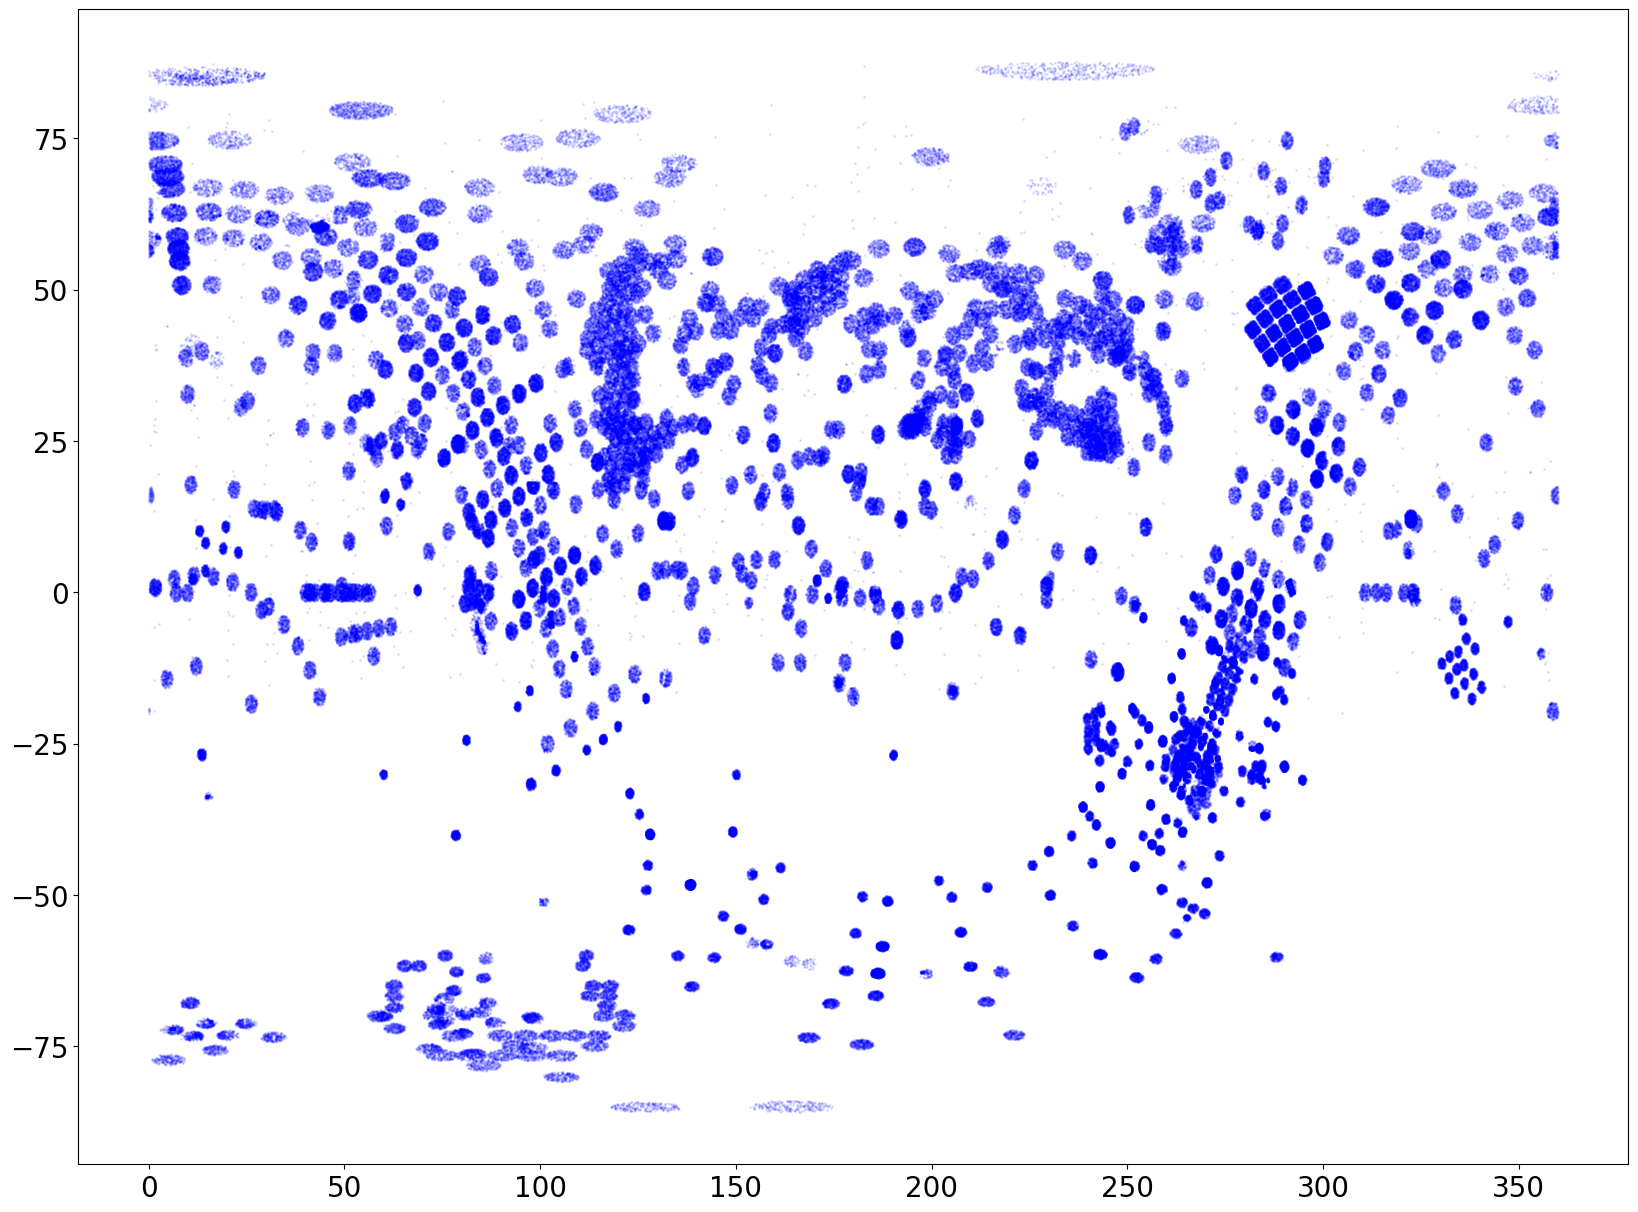

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def logfit(x,a,b,c,d):
    return a*np.log(b*x + c) + d

def gausian(x,mu,sigma):
    part1 = (1.0/np.sqrt(2*np.pi*sigma**2))
    return (part1*(np.exp((-1*x - mu)**2/(2*sigma**2))))

def lorentzian_cauchy (x,a,b,c):
    return (c)*(b**2/((x-a)**2 + b**2))

def sigmoid(x,a,b,c,d):
    return (c/(1 + np.exp(-b*(x-a))) + d)

# READ IN FITS FILES
star_hdus = fits.open('allStar-r12-l33.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

# TWO BITWISE FLAGS FOR BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
good = np.where(gd)[0]


# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

In [28]:
def mcFit2(func, x, y, y_err, x_err, p0=[1,1]):
    slope = list()
    y_ints = list()
    iters = 500
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 

        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])

    return (np.median(slope),np.median(y_ints))


def mcFit3(func, x, y, y_err, x_err,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 

        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

def mcFit4(func, x, y, y_err, x_err, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 

        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])

    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


Best Fit Values of the Parameters:
Linear Fit: Slope:1.199e-03 Intercept:-3.338e+00
2nd Degree Polynomial: a:-2.067e-07 b:3.285e-03 c:-8.429e+00
3rd Degree Polynomial: a:2.188e-12 b:-2.436e-07 c:3.479e-03 d:-8.752e+00
Sigmoid: a:3.486e+03 b:8.250e-04 c:8.397e+00 d:-3.688e+00


C:\Users\April\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


Log: a:3.133e+00 b:5.471e+00 c:-1.128e+04d:-2.751e+01


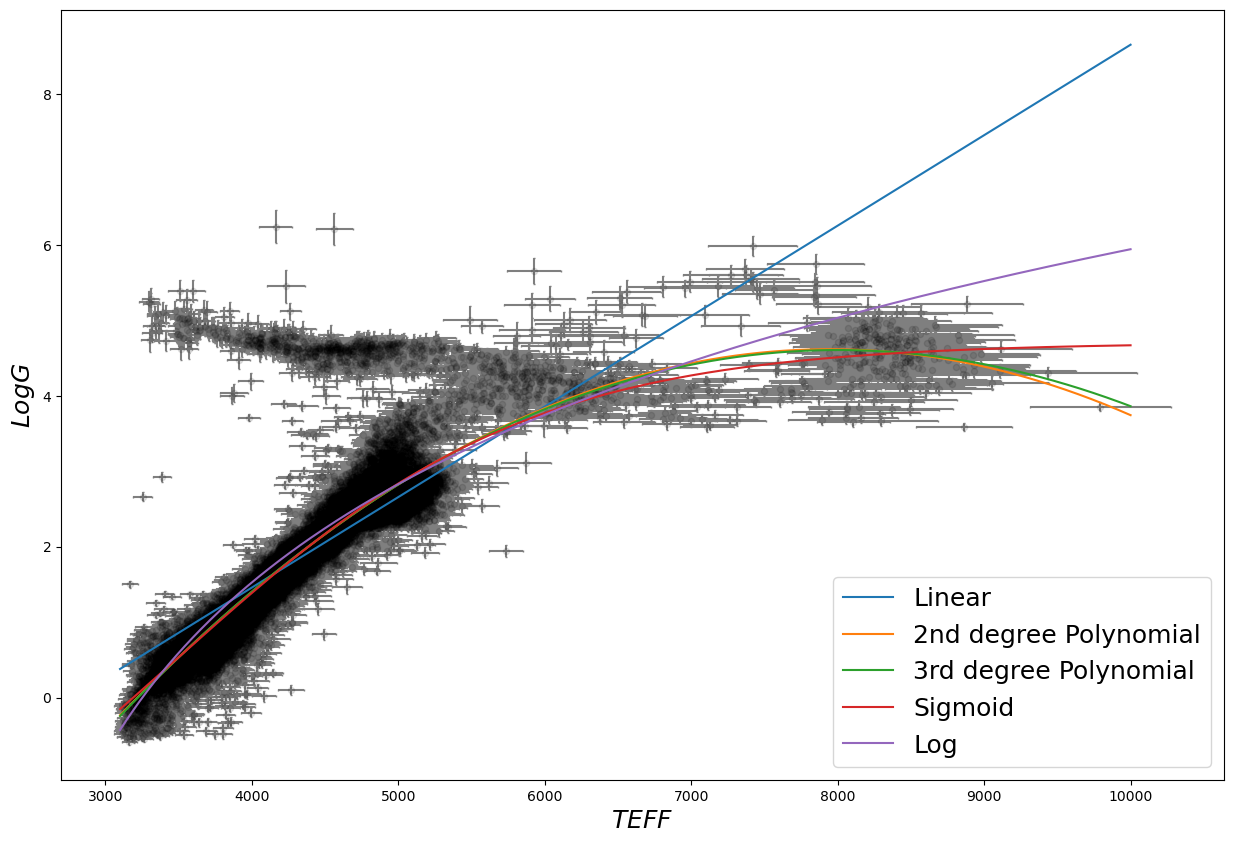

In [33]:
#problem 1 Select stars only with with  −1<𝐺𝐿𝐴𝑇<1, Fit TEFF (TEFF_ERR) vs. LogG (LOGG_ERR)
mask_1 = ((star['GLAT'][good] > -1) & (star['GLAT'][good] <1)) & ((star['TEFF'][good] > -9999) & (star['LOGG'][good] > -9999))
xdat = star['TEFF'][good][mask_1]
ydat = star['LOGG'][good][mask_1]
xdat_err = star['TEFF_ERR'][good][mask_1]
ydat_err = star['LOGG_ERR'][good][mask_1]

print("Best Fit Values of the Parameters:")
slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err)
print('Linear Fit:', "Slope:{:.3e}".format(slope)+" "+"Intercept:{:.3e}".format(intercept))
a_poly_2,b_poly_2,c_poly_2 = mcFit3(poly2, xdat, ydat, ydat_err, xdat_err)
print("2nd Degree Polynomial:", "a:{:.3e}".format(a_poly_2)+" "+"b:{:.3e}".format(b_poly_2)+" "+"c:{:.3e}".format(c_poly_2))
a_poly_3,b_poly_3,c_poly_3,d_poly_3 = mcFit4(poly3, xdat, ydat, ydat_err, xdat_err) 
print("3rd Degree Polynomial:", "a:{:.3e}".format(a_poly_3)+" "+"b:{:.3e}".format(b_poly_3)+" "+"c:{:.3e}".format(c_poly_3)+" "+"d:{:.3e}".format(d_poly_3))
#a_lorentz, b_lorentz, c_lorentz = mcFit3(lorentzian_cauchy,xdat, ydat, ydat_err, xdat_err, p0 = [6500,3050,360])
#print("Lorentzian Cauchy:","a:{:.3f}".format(a_lorentz)+" "+"b:{:.3f}".format(b_lorentz)+" "+"c:{:.3f}".format(c_lorentz) )
a_sig, b_sig, c_sig, d_sig = mcFit4(sigmoid, xdat, ydat, ydat_err, xdat_err, p0=[3200,0.0008,8,-4])
print("Sigmoid:",  "a:{:.3e}".format(a_sig)+" "+"b:{:.3e}".format(b_sig)+" "+"c:{:.3e}".format(c_sig)+" "+"d:{:.3e}".format(d_sig))
a_4,b_4,c_4,d_4 = mcFit4(logfit, xdat, ydat, ydat_err, xdat_err, p0=[2,0.6,-1000,-50])
print("Log:","a:{:.3e}".format(a_4)+" "+"b:{:.3e}".format(b_4)+" "+"c:{:.3e}".format(c_4)+"d:{:.3e}".format(d_4)) 

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
xfine = np.linspace(3100., 10000., 1000) 
ax.scatter(xdat,ydat,s=20,c='black', alpha=0.1)
ax.errorbar(xdat,ydat,xerr= xdat_err,yerr=ydat_err, c='tab:gray', 
            fmt='.', markersize=0.75, capsize=1 ,zorder=0)

ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')
ax.plot(xfine, poly2(xfine, np.mean(a_poly_2), np.mean(b_poly_2), np.mean(c_poly_2)), label='2nd degree Polynomial')
ax.plot(xfine, poly3(xfine, np.mean(a_poly_3), np.mean(b_poly_3), np.mean(c_poly_3), np.mean(d_poly_3)), label='3rd degree Polynomial')

#ax.plot(xfine, lorentzian_cauchy(xfine, np.mean(a_lorentz), np.mean(b_lorentz), np.mean(c_lorentz)), label='Lorenzian Cauchy')
ax.plot(xfine, sigmoid(xfine, np.mean(a_sig), np.mean(b_sig), np.mean(c_sig),np.mean(d_sig)), label='Sigmoid')

ax.plot(xfine, logfit(xfine, np.mean(a_4), np.mean(b_4), np.mean(c_4), np.mean(d_4)), label='Log')


plt.legend(loc='best', fontsize=18)
ax.set_xlabel('$TEFF$', fontsize=18)
ax.set_ylabel('$LogG$', fontsize=18)

plt.show()


The function that fits the data best for the TEFF vs. LogG plot is the 3rd degree Polynomial. The 3rd degree polynomial fit is given in green on the plot. It closely follows the 2nd degree polynomial fit which is also a good fit for this data set.The 3rd degree polynomial is selected as the best fit because it follows the plot shape of the data the closest. There is a set of outlier points that can be fit by the linear function that was excluded from this profile. The linear fit for those outlier points can be seen at the end of this Jupyter Notebook.

Best Fit Values of the Parameters:
Linear Fit: Slope:-2.168e-01 Intercept:4.041e-02
2nd Degree Polynomial: a:-8.038e-02 b:-3.071e-01 c:3.320e-02
3rd Degree Polynomial: a:1.837e-02 b:-4.164e-02 c:-2.941e-01 d:3.229e-02
Cosine: a:2.572e-01 b:1.102e+00 c:1.675e+00 d:5.707e-02
Sigmoid: a:-2.991e-01 b:6.690e+00 c:-2.720e-01 d:2.535e-01
Exponential: a:-8.127e-02 b:7.038e-01 c:1.677e+00 d:4.703e-01


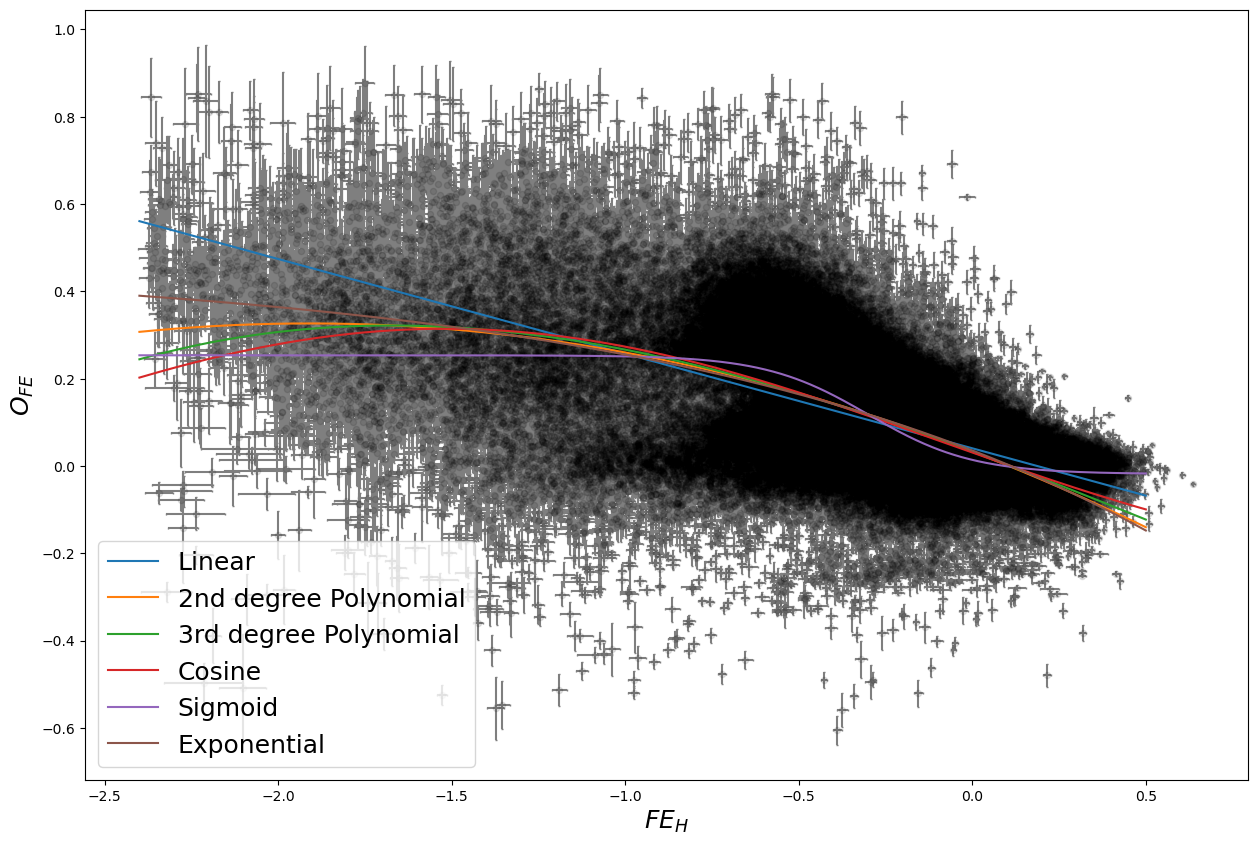

In [32]:
# problem 2: Select stars only with with  𝐺𝐿𝐴𝑇<−10  or  𝐺𝐿𝐴𝑇>10  Fit {\bf Fe_H, (Fe_H_ERR) vs. O_FE (O_FE_ERR)
mask_1 = ((star['GLAT'][good] < -10) | (star['GLAT'][good] >10)) & ((star['Fe_H'][good] > -9999) & (star['O_FE'][good] > -9999))
xdat = star['Fe_H'][good][mask_1]
ydat = star['O_FE'][good][mask_1]
xdat_err = star['Fe_H_ERR'][good][mask_1]
ydat_err = star['O_FE_ERR'][good][mask_1]

print("Best Fit Values of the Parameters:")
slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err)
print('Linear Fit:', "Slope:{:.3e}".format(slope)+" "+"Intercept:{:.3e}".format(intercept))
a_poly_2,b_poly_2,c_poly_2 = mcFit3(poly2, xdat, ydat, ydat_err, xdat_err)
print("2nd Degree Polynomial:", "a:{:.3e}".format(a_poly_2)+" "+"b:{:.3e}".format(b_poly_2)+" "+"c:{:.3e}".format(c_poly_2))
a_poly_3,b_poly_3,c_poly_3,d_poly_3 = mcFit4(poly3, xdat, ydat, ydat_err, xdat_err)
print("3rd Degree Polynomial:", "a:{:.3e}".format(a_poly_3)+" "+"b:{:.3e}".format(b_poly_3)+" "+"c:{:.3e}".format(c_poly_3)+" "+"d:{:.3e}".format(d_poly_3))
a_cos,b_cos,c_cos,d_cos = mcFit4(cosfit, xdat, ydat, ydat_err, xdat_err)
print ("Cosine:","a:{:.3e}".format(a_cos)+" "+"b:{:.3e}".format(b_cos)+" "+"c:{:.3e}".format(c_cos)+" "+"d:{:.3e}".format(d_cos))

#a_lorentz, b_lorentz, c_lorentz = mcFit3(lorentzian_cauchy,xdat, ydat, ydat_err, xdat_err, p0=[-0.2,1,0.7])
#print("Lorentzian Cauchy:","a:{:.3e}".format(a_lorentz)+" "+"b:{:.3e}".format(b_lorentz)+" "+"c:{:.3e}".format(c_lorentz) )
a_sig, b_sig, c_sig, d_sig = mcFit4(sigmoid, xdat, ydat, ydat_err, xdat_err, p0=[-0.5,10,-0.5,0.5])
print("Sigmoid:",  "a:{:.3e}".format(a_sig)+" "+"b:{:.3e}".format(b_sig)+" "+"c:{:.3e}".format(c_sig)+" "+"d:{:.3e}".format(d_sig))
#a_4,b_4,c_4,d_4 = mcFit4(logfit, xdat, ydat, ydat_err, xdat_err, p0=[0.2,0.1,0.3,0.4])
#print("Log:","a:{:.3e}".format(a_4)+" "+"b:{:.3e}".format(b_4)+" "+"c:{:.3e}".format(c_4)+" "+"d:{:.3e}".format(d_4)) 
a_exp,b_exp,c_exp,d_exp = mcFit4(exponential,xdat, ydat, ydat_err, xdat_err, p0=[-0.1,0.3,1.9,1])
print("Exponential:", "a:{:.3e}".format(a_exp)+" "+"b:{:.3e}".format(b_exp)+" "+"c:{:.3e}".format(c_exp)+" "+"d:{:.3e}".format(d_exp))

xfine = np.linspace(-2.4, 0.5, 1000)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(xdat,ydat,s=20,c='black',alpha=0.1)
ax.errorbar(xdat,ydat,xerr= xdat_err,yerr=ydat_err, c='tab:gray', 
            fmt='.', markersize=0.75, capsize=1 ,zorder=0)

ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')
ax.plot(xfine, poly2(xfine, np.mean(a_poly_2), np.mean(b_poly_2), np.mean(c_poly_2)), label='2nd degree Polynomial')
ax.plot(xfine, poly3(xfine, np.mean(a_poly_3), np.mean(b_poly_3), np.mean(c_poly_3), np.mean(d_poly_3)), label='3rd degree Polynomial')
ax.plot(xfine, cosfit(xfine, np.mean(a_cos), np.mean(b_cos), np.mean(c_cos), np.mean(d_cos)), label='Cosine')
#ax.plot(xfine, lorentzian_cauchy(xfine, np.mean(a_lorentz), np.mean(b_lorentz), np.mean(c_lorentz)), label='Lorenzian Cauchy')
ax.plot(xfine, sigmoid(xfine, np.mean(a_sig), np.mean(b_sig), np.mean(c_sig),np.mean(d_sig)), label='Sigmoid')

#ax.plot(xfine, logfit(xfine, np.mean(a_4), np.mean(b_4), np.mean(c_4), np.mean(d_4)), label='Log')
ax.plot(xfine, exponential(xfine, np.mean(a_exp), np.mean(b_exp), np.mean(c_exp), np.mean(d_exp)), label='Exponential')

plt.legend(loc='best', fontsize=18)


ax.set_xlabel('$FE_{H}$', fontsize=18)
ax.set_ylabel('$O_{FE}$', fontsize=18)

plt.show()


The Fe_H vs. O_FE graph is best fitted by the cosine, and polynomial functions. These functions follow the slight drop off of the high density area of points at the end of the plot. 

Best Fit Values of the Parameters:
Linear Fit: Slope:-1.637e-01 Intercept:4.107e-02
3rd Degree Polynomial: a:1.145e-01 b:1.669e-01 c:-1.484e-01 d:3.125e-02
Cosine: a:1.174e-01 b:2.004e+00 c:2.471e+00 d:1.225e-01
Lorentzian Cauchy: a:-8.709e-01 b:3.981e-01 c:2.358e-01
Sigmoid: a:-4.000e-01 b:4.120e+00 c:-2.404e-01 d:2.325e-01


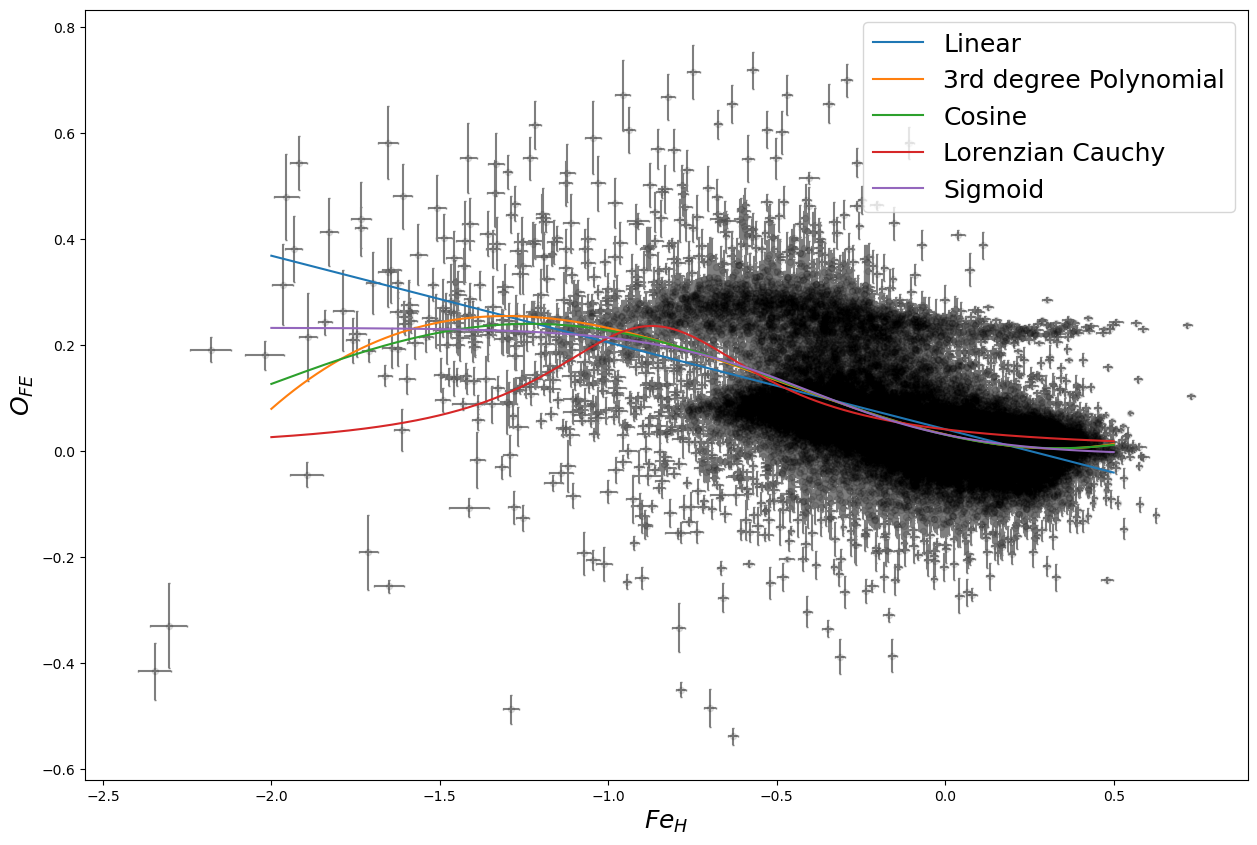

In [189]:
#problem 3 Select stars only with with  −2<𝐺𝐿𝐴𝑇<2 Fit {\bf Fe_H, (Fe_H_ERR) vs. O_FE (O_FE_ERR)
mask_1 = ((star['GLAT'][good] > -2) & (star['GLAT'][good] <2)) & ((star['Fe_H'][good] > -9999) & (star['O_FE'][good] > -9999))
xdat = star['Fe_H'][good][mask_1]
ydat = star['O_FE'][good][mask_1]
xdat_err = star['Fe_H_ERR'][good][mask_1]
ydat_err = star['O_FE_ERR'][good][mask_1]

print("Best Fit Values of the Parameters:")
slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err)
print('Linear Fit:', "Slope:{:.3e}".format(slope)+" "+"Intercept:{:.3e}".format(intercept))
#a_poly_2,b_poly_2,c_poly_2 = mcFit3(poly2, xdat, ydat, ydat_err, xdat_err, p0=[0.01,-0.1,0.03])
#print(a_poly_2,b_poly_2,c_poly_2)
a_poly_3,b_poly_3,c_poly_3,d_poly_3 = mcFit4(poly3, xdat, ydat, ydat_err, xdat_err, p0=[0.2, 0.2, -0.1,0.03])
print("3rd Degree Polynomial:", "a:{:.3e}".format(a_poly_3)+" "+"b:{:.3e}".format(b_poly_3)+" "+"c:{:.3e}".format(c_poly_3)+" "+"d:{:.3e}".format(d_poly_3))
a_cos,b_cos,c_cos,d_cos = mcFit4(cosfit, xdat, ydat, ydat_err, xdat_err)
print ("Cosine:","a:{:.3e}".format(a_cos)+" "+"b:{:.3e}".format(b_cos)+" "+"c:{:.3e}".format(c_cos)+" "+"d:{:.3e}".format(d_cos))
#mu, sigma = mcFit2(gausian,xdat, ydat, ydat_err, xdat_err, p0=[-1.6,1.8])

a_lorentz, b_lorentz, c_lorentz = mcFit3(lorentzian_cauchy,xdat, ydat, ydat_err, xdat_err, p0=[0,0.7,0.2])
print("Lorentzian Cauchy:","a:{:.3e}".format(a_lorentz)+" "+"b:{:.3e}".format(b_lorentz)+" "+"c:{:.3e}".format(c_lorentz) )
a_sig, b_sig, c_sig, d_sig = mcFit4(sigmoid, xdat, ydat, ydat_err, xdat_err, p0=[0.5,4,-0.2,0.2])
print("Sigmoid:",  "a:{:.3e}".format(a_sig)+" "+"b:{:.3e}".format(b_sig)+" "+"c:{:.3e}".format(c_sig)+" "+"d:{:.3e}".format(d_sig))
#a_4,b_4,c_4,d_4 = mcFit4(logfit, xdat, ydat, ydat_err, xdat_err, p0=[-0.5,-1.2,1.4,-0.8])
#print(a_4,b_4,c_4,d_4)
#a_exp,b_exp,c_exp,d_exp = mcFit4(exponential,xdat, ydat, ydat_err, xdat_err, p0=[0.7,-0.1,0.1,-0.7])
#print(a_exp,b_exp,c_exp,d_exp)

xfine = np.linspace(-2, 0.5, 1000)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(xdat,ydat,s=20,c='black',alpha=0.1)
ax.errorbar(xdat,ydat,xerr= xdat_err,yerr=ydat_err, c='tab:gray', 
            fmt='.', markersize=0.75, capsize=1 ,zorder=0)
ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')
ax.plot(xfine, poly3(xfine, np.mean(a_poly_3), np.mean(b_poly_3), np.mean(c_poly_3), np.mean(d_poly_3)), label='3rd degree Polynomial')
ax.plot(xfine, cosfit(xfine, np.mean(a_cos), np.mean(b_cos), np.mean(c_cos), np.mean(d_cos)), label='Cosine')
ax.plot(xfine, lorentzian_cauchy(xfine, np.mean(a_lorentz), np.mean(b_lorentz), np.mean(c_lorentz)), label='Lorenzian Cauchy')
ax.plot(xfine, sigmoid(xfine, np.mean(a_sig), np.mean(b_sig), np.mean(c_sig),np.mean(d_sig)), label='Sigmoid')




plt.legend(loc='best', fontsize=18)



ax.set_xlabel('$Fe_{H}$', fontsize=18)
ax.set_ylabel('$O_{FE}$', fontsize=18)

plt.show()


The Fe_H vs. O_FE profile is best fit by either the 3rd degree polynomial or the cosine function. Both line profiles follow almost the same path and produce the curved up shape at the high density region at the end of the plot. 

Best Fit Values of the Parameters:
2nd Degree Polynomial: a:2.707e-08 b:-5.614e-04 c:2.736e+00
3rd Degree Polynomial: a:1.323e-11 b:-1.917e-07 c:6.108e-04 d:6.979e-01
Lorentzian Cauchy: a:3.647e+03 b:1.654e+03 c:9.949e-01
Exponential: a:5.243e-01 b:-1.665e-04 c:2.024e+00 d:-1.118e+00


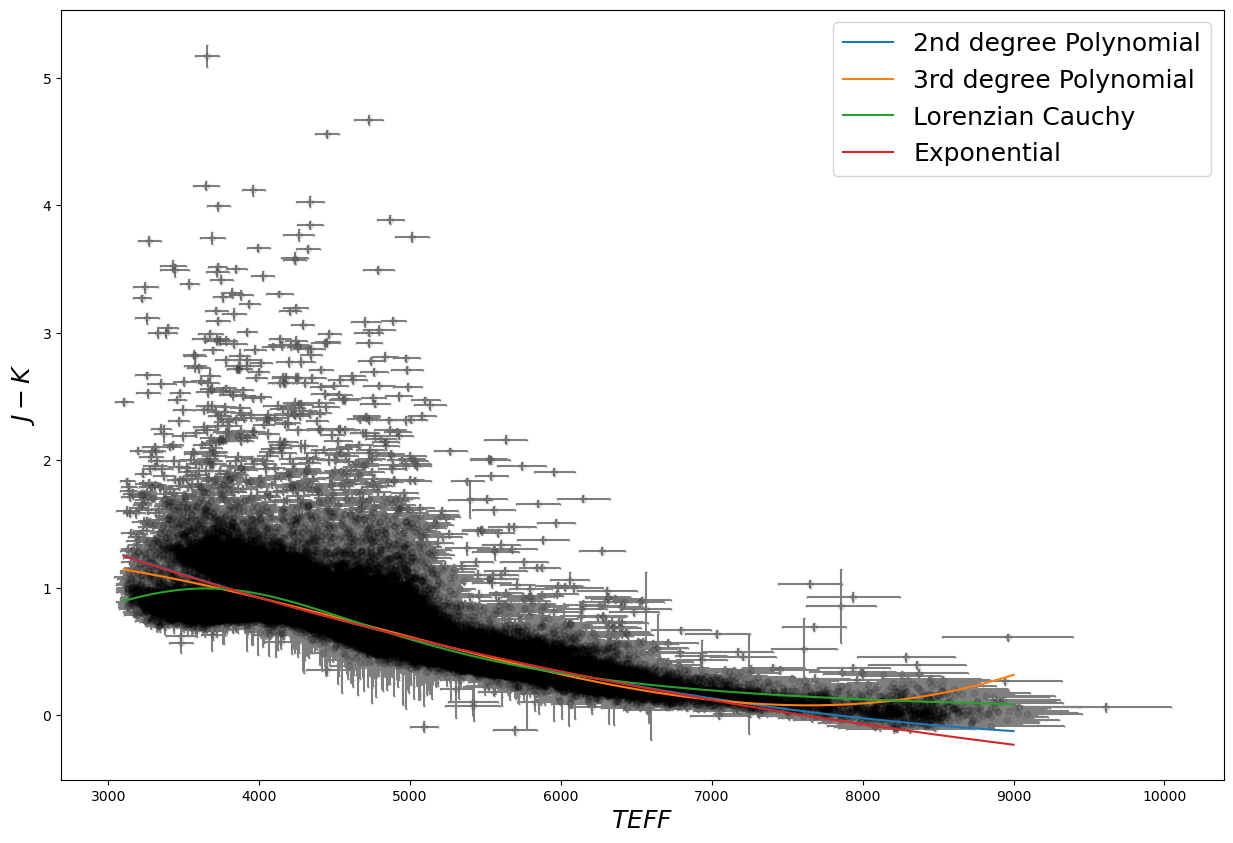

In [34]:
#problem 4 Select stars only with with  𝐺𝐿𝐴𝑇<−10  or  𝐺𝐿𝐴𝑇>10  Fit {\bf TEFF, (TEFF_ERR) vs. (J - K) (J_ERR, K_ERR)
mask_1 = ((star['GLAT'][good] < -10) | (star['GLAT'][good] >10)) &(star['TEFF'][good] > -9999) & ((star['J'][good]-star['K'][good])<9999) & (np.sqrt(star['J_ERR'][good]**2+star['K_ERR'][good]**2)<8)
xdat = star['TEFF'][good][mask_1]
ydat = star['J'][good][mask_1]-star['K'][good][mask_1]
xdat_err = star['TEFF_ERR'][good][mask_1]
ydat_err = np.sqrt(star['J_ERR'][good][mask_1]**2+star['K_ERR'][good][mask_1]**2)

print("Best Fit Values of the Parameters:")
#slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err)
#print('Linear Fit:', "Slope:{:.3e}".format(slope)+" "+"Intercept:{:.3e}".format(intercept))
a_poly_2,b_poly_2,c_poly_2 = mcFit3(poly2, xdat, ydat, ydat_err, xdat_err)
print("2nd Degree Polynomial:", "a:{:.3e}".format(a_poly_2)+" "+"b:{:.3e}".format(b_poly_2)+" "+"c:{:.3e}".format(c_poly_2))
a_poly_3,b_poly_3,c_poly_3,d_poly_3 = mcFit4(poly3, xdat, ydat, ydat_err, xdat_err)
print("3rd Degree Polynomial:", "a:{:.3e}".format(a_poly_3)+" "+"b:{:.3e}".format(b_poly_3)+" "+"c:{:.3e}".format(c_poly_3)+" "+"d:{:.3e}".format(d_poly_3))

a_lorentz, b_lorentz, c_lorentz = mcFit3(lorentzian_cauchy,xdat, ydat, ydat_err, xdat_err, p0=[4000,1000,1.5])
print("Lorentzian Cauchy:","a:{:.3e}".format(a_lorentz)+" "+"b:{:.3e}".format(b_lorentz)+" "+"c:{:.3e}".format(c_lorentz) )
#a_sig, b_sig, c_sig, d_sig = mcFit4(sigmoid, xdat, ydat, ydat_err, xdat_err,p0=[4000,6,2.5,0.3])
#print("Sigmoid:",  "a:{:.3e}".format(a_sig)+" "+"b:{:.3e}".format(b_sig)+" "+"c:{:.3e}".format(c_sig)+" "+"d:{:.3e}".format(d_sig))
#a_4,b_4,c_4,d_4 = mcFit4(logfit, xdat, ydat, ydat_err, xdat_err, p0=[-5,0.5,850,25])
#print("Log:","a:{:.3e}".format(a_4)+" "+"b:{:.3e}".format(b_4)+" "+"c:{:.3e}".format(c_4)+" "+"d:{:.3e}".format(d_4)) 
a_exp,b_exp,c_exp,d_exp = mcFit4(exponential,xdat, ydat, ydat_err, xdat_err, p0=[0,0,0,0])
print("Exponential:", "a:{:.3e}".format(a_exp)+" "+"b:{:.3e}".format(b_exp)+" "+"c:{:.3e}".format(c_exp)+" "+"d:{:.3e}".format(d_exp))



xfine = np.linspace(3100, 9000, 1000)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(xdat,ydat,s=20,c='black',alpha=0.1)
ax.errorbar(xdat,ydat,xerr= xdat_err,yerr=ydat_err, c='tab:gray', 
            fmt='.', markersize=0.75, capsize=1 ,zorder=0)
#ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')
ax.plot(xfine, poly2(xfine, np.mean(a_poly_2), np.mean(b_poly_2), np.mean(c_poly_2)), label='2nd degree Polynomial')
ax.plot(xfine, poly3(xfine, np.mean(a_poly_3), np.mean(b_poly_3), np.mean(c_poly_3), np.mean(d_poly_3)), label='3rd degree Polynomial')
ax.plot(xfine, lorentzian_cauchy(xfine, np.mean(a_lorentz), np.mean(b_lorentz), np.mean(c_lorentz)), label='Lorenzian Cauchy')
#ax.plot(xfine, sigmoid(xfine, np.mean(a_sig), np.mean(b_sig), np.mean(c_sig),np.mean(d_sig)), label='Sigmoid')
#ax.plot(xfine, logfit(xfine, np.mean(a_4), np.mean(b_4), np.mean(c_4), np.mean(d_4)), label='Log')
ax.plot(xfine, exponential(xfine, np.mean(a_exp), np.mean(b_exp), np.mean(c_exp), np.mean(d_exp)), label='Exponential')

plt.legend(loc='best', fontsize=18)

ax.set_xlabel('$TEFF$', fontsize=18)
ax.set_ylabel('$J-K$', fontsize=18)

plt.show()


I did not include the linear plot on the TEFF vs. J-K profile as it did not fit the data well and was crowding the plot and making it hard to see the other well fitting lines. The function that fits this profile the best is the Lorenzian Cauchy. The Lorenzian Cauchy line fits the general trend of the high density data point areas the best. The data slowly rises and then levels off. There is a set of outlier points that can be fit by the linear function that was excluded from this profile. The linear fit for those outlier points can be seen at the end of this Jupyter Notebook.

Best Fit Values of the Parameters:
Linear Fit: Slope:-7.536e-03 Intercept:-4.065e+00
3rd Degree Polynomial: a:-3.286e-05 b:1.718e-02 c:-2.204e+00 d:4.046e+01
Cosine: a:5.615e+01 b:2.269e-02 c:-5.502e+00 d:1.235e+00


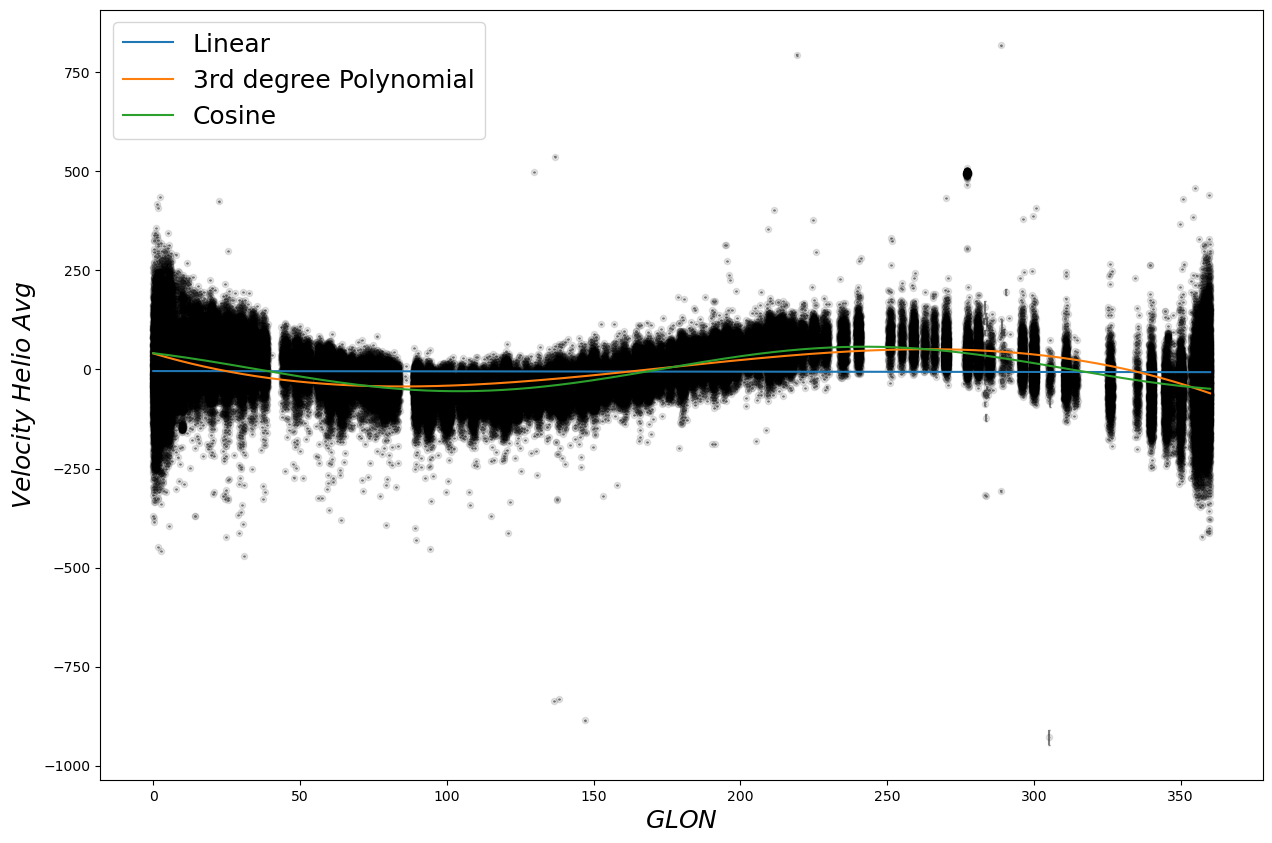

In [35]:
#problem 5 Select stars only with with  −10<𝐺𝐿𝐴𝑇<10 Fit {\bf GLON vs. VHEILO_AVG (VERR)



mask_1 = ((star['GLAT'][good] > -10) & (star['GLAT'][good] < 10)) & ((star['VHELIO_AVG'][good]) < 1e5)
xdat = star['GLON'][good][mask_1]
ydat = star['VHELIO_AVG'][good][mask_1]
ydat_err = star['VERR'][good][mask_1]
xdat_err = 0

print("Best Fit Values of the Parameters:")
slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err)
print('Linear Fit:', "Slope:{:.3e}".format(slope)+" "+"Intercept:{:.3e}".format(intercept))
a_poly_3,b_poly_3,c_poly_3,d_poly_3 = mcFit4(poly3, xdat, ydat, ydat_err, xdat_err)
print("3rd Degree Polynomial:", "a:{:.3e}".format(a_poly_3)+" "+"b:{:.3e}".format(b_poly_3)+" "+"c:{:.3e}".format(c_poly_3)+" "+"d:{:.3e}".format(d_poly_3))
a_cos,b_cos,c_cos,d_cos = mcFit4(cosfit, xdat, ydat, ydat_err, xdat_err, p0=[8,0.01,-2.3,1.8])
print ("Cosine:","a:{:.3e}".format(a_cos)+" "+"b:{:.3e}".format(b_cos)+" "+"c:{:.3e}".format(c_cos)+" "+"d:{:.3e}".format(d_cos))
#print(mu,sigma)
#a_sig, b_sig, c_sig, d_sig = mcFit4(sigmoid, xdat, ydat, ydat_err, xdat_err, p0=[200,-1,-40,20])
#print(a_sig, b_sig, c_sig, d_sig)
#a_4,b_4,c_4,d_4 = mcFit4(logfit, xdat, ydat, ydat_err, xdat_err, p0=[-4,5,10,7])###############
#print(a_4,b_4,c_4,d_4)
#a_exp,b_exp,c_exp,d_exp = mcFit4(exponential,xdat, ydat, ydat_err, xdat_err, p0=[1,-0.01,1,1])
#print(a_exp,b_exp,c_exp,d_exp)


xfine = np.linspace(0, 360, 1000)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(xdat,ydat,s=20,c='black', alpha=0.1)
ax.errorbar(xdat,ydat,yerr=ydat_err, c='tab:gray', 
            fmt='.', markersize=0.75, capsize=1 ,zorder=0)

ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')
ax.plot(xfine, poly3(xfine, np.mean(a_poly_3), np.mean(b_poly_3), np.mean(c_poly_3), np.mean(d_poly_3)), label='3rd degree Polynomial')
ax.plot(xfine, cosfit(xfine, np.mean(a_cos), np.mean(b_cos), np.mean(c_cos), np.mean(d_cos)), label='Cosine')



plt.legend(loc='best', fontsize=18)



ax.set_xlabel('$GLON$', fontsize=18)
ax.set_ylabel('$Velocity$ $Helio$ $Avg$', fontsize=18)

plt.show()


Linear is not a great fit for the GLON vs. VHEILO_AVG plot but I included it on the profile just for reference. The cosine function fits this profile the best. The data has an almost cosine shape pattern to it already. The cosine function does a better job at matching the maximum and minimum points on the data profile. 

Best Fit Values of the Parameters:
Linear Fit: Slope:6.599e-02 Intercept:1.614e-01
Lorentzian Cauchy: a:2.034e+01 b:-9.406e+00 c:1.638e+00


C:\Users\April\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


Log: a:3.983e-01 b:3.627e+00 c:5.958e-01 d:-5.470e-01
Exponential: a:-4.853e+00 b:-1.384e-01 c:-1.230e+00 d:1.330e+00


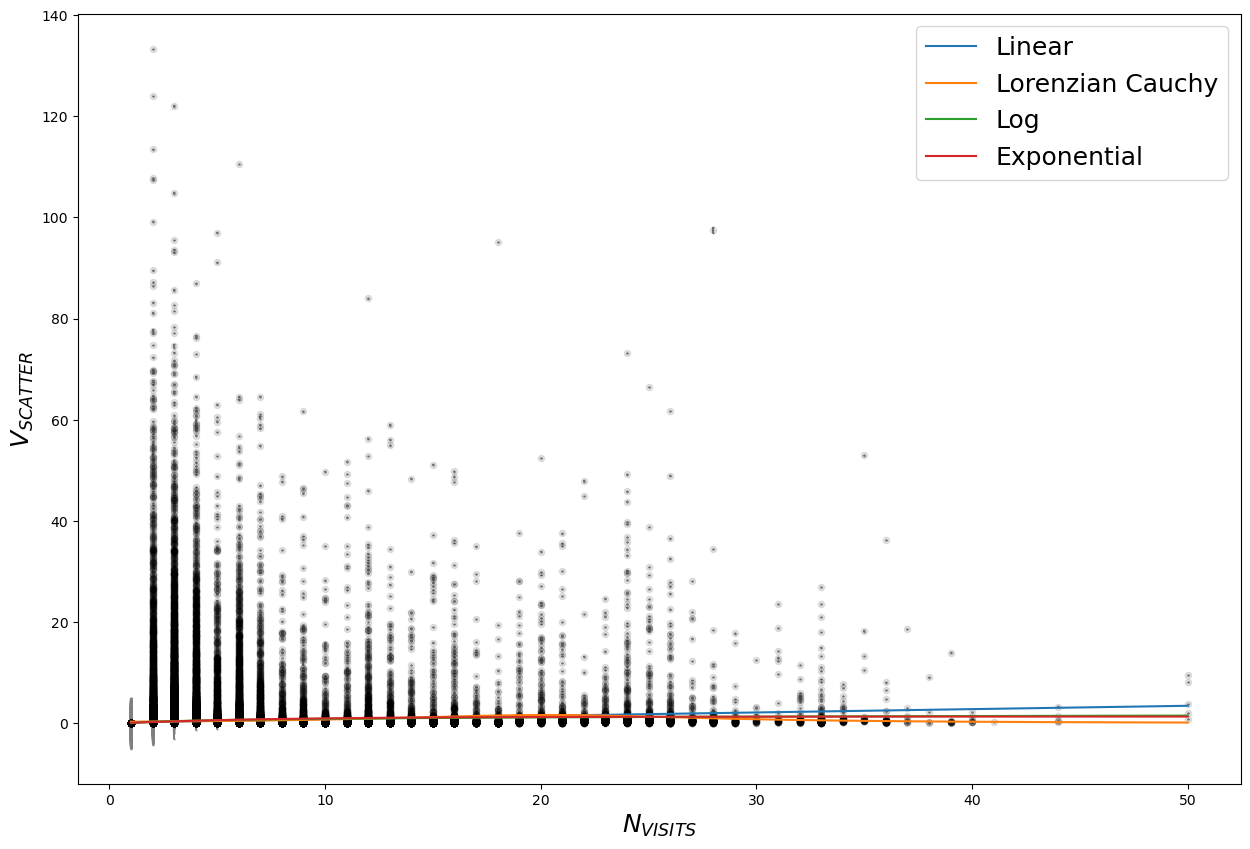

In [29]:
#problem 6 Fit {\bf NVISITS vs. VSCATTER (VERR) For NVISITS  >=1
mask_1 = ((star['NVISITS'][good] == 1) | (star['NVISITS'][good] > 1)) & (star['VERR'][good]<5)

xdat = star['NVISITS'][good][mask_1]
ydat = star['VSCATTER'][good][mask_1]
ydat_err = star['VERR'][good][mask_1]
xdat_err = 0 #because there is no error in the x direction

print("Best Fit Values of the Parameters:")
slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err)
print('Linear Fit:', "Slope:{:.3e}".format(slope)+" "+"Intercept:{:.3e}".format(intercept))
a_lorentz, b_lorentz, c_lorentz = mcFit3(lorentzian_cauchy,xdat, ydat, ydat_err, xdat_err, p0=[0,-2,75])
print("Lorentzian Cauchy:","a:{:.3e}".format(a_lorentz)+" "+"b:{:.3e}".format(b_lorentz)+" "+"c:{:.3e}".format(c_lorentz) )
a_4,b_4,c_4,d_4 = mcFit4(logfit, xdat, ydat, ydat_err, xdat_err,p0=[-14,2,-1,40])
print("Log:","a:{:.3e}".format(a_4)+" "+"b:{:.3e}".format(b_4)+" "+"c:{:.3e}".format(c_4)+" "+"d:{:.3e}".format(d_4)) 
a_exp,b_exp,c_exp,d_exp = mcFit4(exponential,xdat, ydat, ydat_err, xdat_err, p0=[1.1,-4,3,0])
print("Exponential:", "a:{:.3e}".format(a_exp)+" "+"b:{:.3e}".format(b_exp)+" "+"c:{:.3e}".format(c_exp)+" "+"d:{:.3e}".format(d_exp))


xfine = np.linspace(1, 50, 1000)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(xdat,ydat,s=20,c='black',alpha=0.1)
ax.errorbar(xdat,ydat,yerr=ydat_err, c='tab:gray',fmt='.', markersize=0.75, capsize=1 ,zorder=0)

ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')

ax.plot(xfine, lorentzian_cauchy(xfine, np.mean(a_lorentz), np.mean(b_lorentz), np.mean(c_lorentz)), label='Lorenzian Cauchy')

ax.plot(xfine, logfit(xfine, np.mean(a_4), np.mean(b_4), np.mean(c_4), np.mean(d_4)), label='Log')

ax.plot(xfine, exponential(xfine, np.mean(a_exp), np.mean(b_exp), np.mean(c_exp), np.mean(d_exp)), label='Exponential')


plt.legend(loc='best', fontsize=18)
ax.set_xlabel('$N_{VISITS}$', fontsize=18)
ax.set_ylabel('$V_{SCATTER}$', fontsize=18)

plt.show()

The Nvisits Vs. Vscatter plot is a histogram and takes the form of the Lorenzian Cauchy, Log, and Exponential profiles. However, because of the higher density of points at zero, all of these fits take more of a linear fit when MCfits consider the uncertainties and the density of points at the origin. All of the best fits follow the same linear trend and therefore, are all the essentially the same fit for this profile of data. Ideally, if there wasn't such a high density of points at zero, the log and exponential profiles should fit this data the best but there aren't enough data points up around 60 to produce a decreasing curve. 

Best Fit Values of the Parameters:
Linear Fit: Slope:1.061e-02 Intercept:2.125e-02
2nd Degree Polynomial: a:1.225e-02 b:2.193e-02 c:2.163e-02
3rd Degree Polynomial: a:2.227e-02 b:5.482e-02 c:3.215e-02 d:2.002e-02
Sigmoid: a:1.864e-01 b:2.408e+01 c:4.871e-02 d:1.457e-02


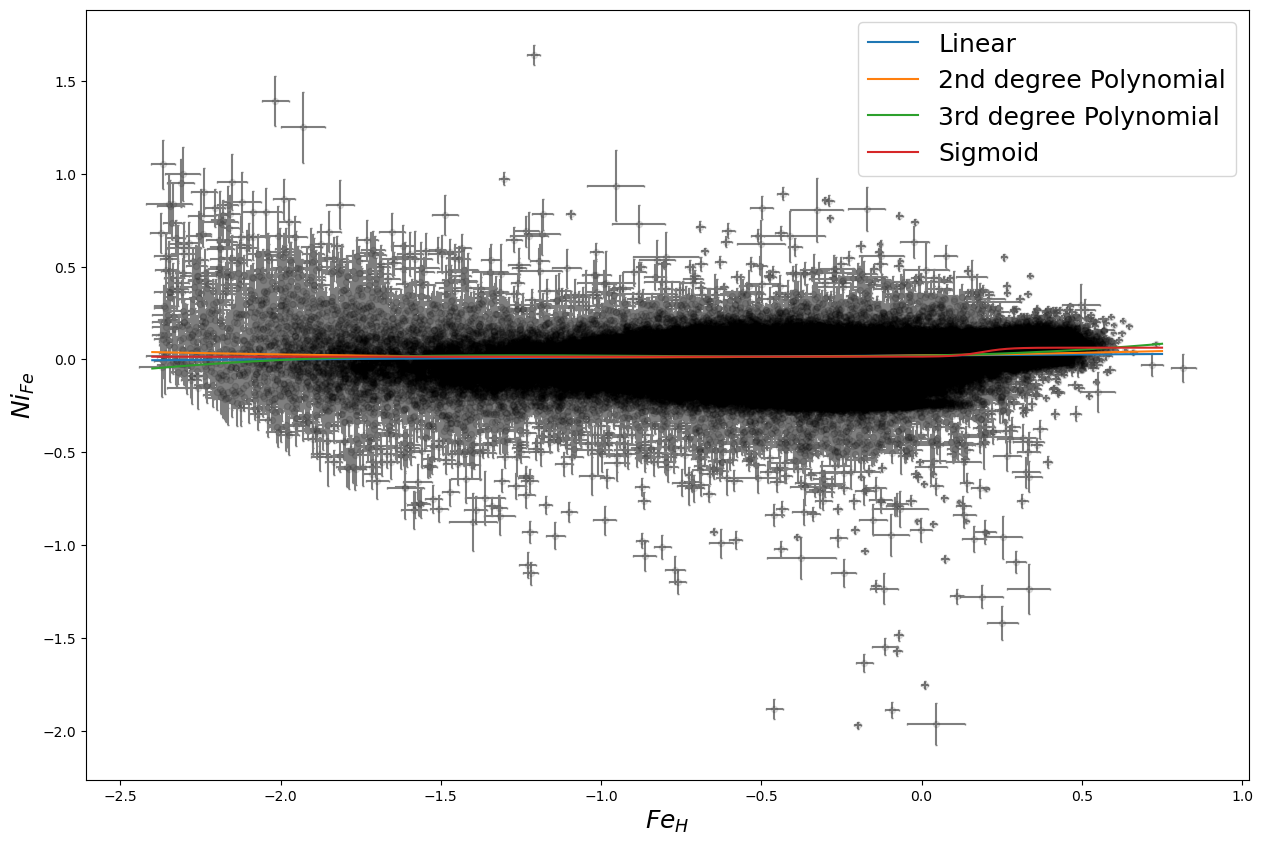

In [36]:
#problem 7 Fit {\bf Fe_H, (Fe_H_ERR) vs. NI_FE (NI_FE_ERR)
mask_1= ((star['Fe_H'][good] > -9999) & (star['NI_FE'][good] > -9999))
xdat = star['Fe_H'][good][mask_1]
ydat = star['NI_FE'][good][mask_1]
xdat_err = star['Fe_H_ERR'][good][mask_1]
ydat_err = star['NI_FE_ERR'][good][mask_1]

print("Best Fit Values of the Parameters:")
slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err)
print('Linear Fit:', "Slope:{:.3e}".format(slope)+" "+"Intercept:{:.3e}".format(intercept))
a_poly_2,b_poly_2,c_poly_2 = mcFit3(poly2, xdat, ydat, ydat_err, xdat_err)
print("2nd Degree Polynomial:", "a:{:.3e}".format(a_poly_2)+" "+"b:{:.3e}".format(b_poly_2)+" "+"c:{:.3e}".format(c_poly_2))
a_poly_3,b_poly_3,c_poly_3,d_poly_3 = mcFit4(poly3, xdat, ydat, ydat_err, xdat_err)
print("3rd Degree Polynomial:", "a:{:.3e}".format(a_poly_3)+" "+"b:{:.3e}".format(b_poly_3)+" "+"c:{:.3e}".format(c_poly_3)+" "+"d:{:.3e}".format(d_poly_3))
#mu, sigma = mcFit2(gausian,xdat, ydat, ydat_err, xdat_err, p0=[-0.1,3])
#print("Gaussian:", "mu:{:.3e}".format(mu)+" "+"sigma:{:.3e}".format(sigma))
#a_lorentz, b_lorentz, c_lorentz = mcFit3(lorentzian_cauchy,xdat, ydat, ydat_err, xdat_err, p0=[1.2,0.4,0.1])
#print("Lorentzian Cauchy:","a:{:.3e}".format(a_lorentz)+" "+"b:{:.3e}".format(b_lorentz)+" "+"c:{:.3e}".format(c_lorentz) )
a_sig, b_sig, c_sig, d_sig = mcFit4(sigmoid, xdat, ydat, ydat_err, xdat_err)
print("Sigmoid:",  "a:{:.3e}".format(a_sig)+" "+"b:{:.3e}".format(b_sig)+" "+"c:{:.3e}".format(c_sig)+" "+"d:{:.3e}".format(d_sig))
#a_4,b_4,c_4,d_4 = mcFit4(logfit, xdat, ydat, ydat_err, xdat_err, p0=[-0.8,-0.2,1.2,0.1])
#print("Log:","a:{:.3e}".format(a_4)+" "+"b:{:.3e}".format(b_4)+" "+"c:{:.3e}".format(c_4)+" "+"d:{:.3e}".format(d_4)) 
#a_exp,b_exp,c_exp,d_exp = mcFit4(exponential,xdat, ydat, ydat_err, xdat_err,p0=[0,1,-3,0])
#print("Exponential:", "a:{:.3e}".format(a_exp)+" "+"b:{:.3e}".format(b_exp)+" "+"c:{:.3e}".format(c_exp)+" "+"d:{:.3e}".format(d_exp))

xfine = np.linspace(-2.4, 0.75, 1000)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(xdat,ydat,s=20,c='black',alpha=0.1)
ax.errorbar(xdat,ydat,xerr= xdat_err,yerr=ydat_err, c='tab:gray', 
            fmt='.', markersize=0.75, capsize=1 ,zorder=0)
ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')
ax.plot(xfine, poly2(xfine, np.mean(a_poly_2), np.mean(b_poly_2), np.mean(c_poly_2)), label='2nd degree Polynomial')
ax.plot(xfine, poly3(xfine, np.mean(a_poly_3), np.mean(b_poly_3), np.mean(c_poly_3), np.mean(d_poly_3)), label='3rd degree Polynomial')
#ax.plot(xfine, lorentzian_cauchy(xfine, np.mean(a_lorentz), np.mean(b_lorentz), np.mean(c_lorentz)), label='Lorenzian Cauchy')
ax.plot(xfine, sigmoid(xfine, np.mean(a_sig), np.mean(b_sig), np.mean(c_sig),np.mean(d_sig)), label='Sigmoid')
#ax.plot(xfine, gausian(xfine, np.mean(mu), np.mean(sigma)), label='Gausian')
#ax.plot(xfine, logfit(xfine, np.mean(a_4), np.mean(b_4), np.mean(c_4), np.mean(d_4)), label='Log')
#ax.plot(xfine, exponential(xfine, np.mean(a_exp), np.mean(b_exp), np.mean(c_exp), np.mean(d_exp)), label='Exponential')

plt.legend(loc='best', fontsize=18)
ax.set_xlabel('$Fe_{H}$', fontsize=18)
ax.set_ylabel('$Ni_{Fe}$', fontsize=18)

plt.show()


This Fe_H vs. NI_FE plot follows a pretty linear trend. The high density points form a nice straight profile except at the very end of the plot. There is a small blob of data points at the end that increase ever so slightly. Because this behavior is present in the plot, the sigmoid function fits the data the best. It keeps a standard linear profile until the end where it slightly increases its slope and levels off at a higher point just like the data points. 

Best Fit Values of the Parameters:
Linear Fit: Slope:7.402e-03 Intercept:-1.004e+04


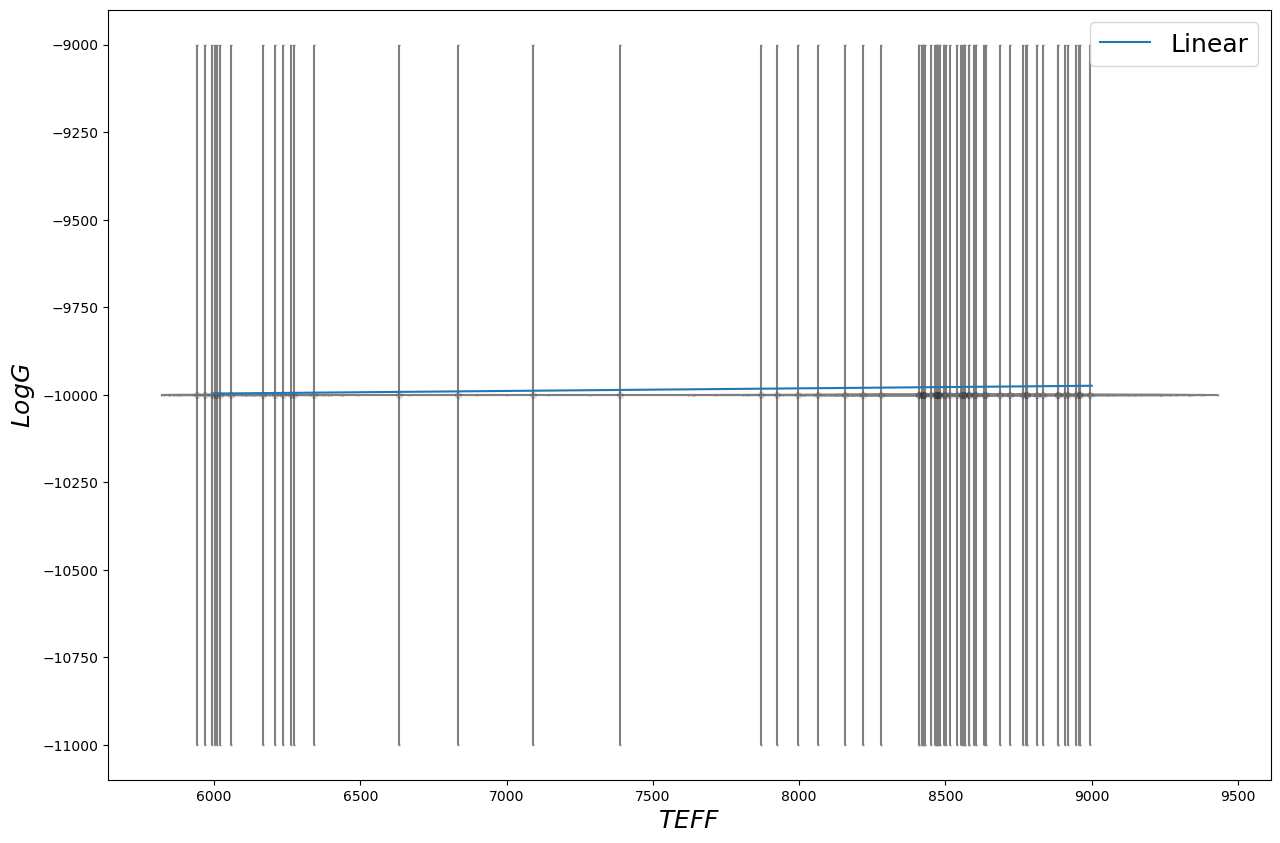

In [47]:

mask_1 = ((star['GLAT'][good] > -1) & (star['GLAT'][good] <1)) & ((star['TEFF'][good] > -9999) & (star['LOGG'][good] < -9999))
xdat = star['TEFF'][good][mask_1]
ydat = star['LOGG'][good][mask_1]
xdat_err = star['TEFF_ERR'][good][mask_1]
ydat_err = star['LOGG_ERR'][good][mask_1]

print("Best Fit Values of the Parameters:")
slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err,p0=[0,-9999])
print('Linear Fit:', "Slope:{:.3e}".format(slope)+" "+"Intercept:{:.3e}".format(intercept))

xfine = np.linspace(6000, 9000, 10)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
 
ax.scatter(xdat,ydat,s=20,c='black', alpha=0.1)
ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')


ax.errorbar(xdat,ydat,xerr= xdat_err,yerr=ydat_err, c='tab:gray', 
            fmt='.', markersize=0.75, capsize=1 ,zorder=0)

plt.legend(loc='best', fontsize=18)
ax.set_xlabel('$TEFF$', fontsize=18)
ax.set_ylabel('$LogG$', fontsize=18)

plt.show()


This is the set of outlier points that can be fit by the linear function that was excluded from the TEFF vs. LogG profile in problem 1. 

Linear Fit: Slope:-9.403e-02 Intercept:1.043e+04


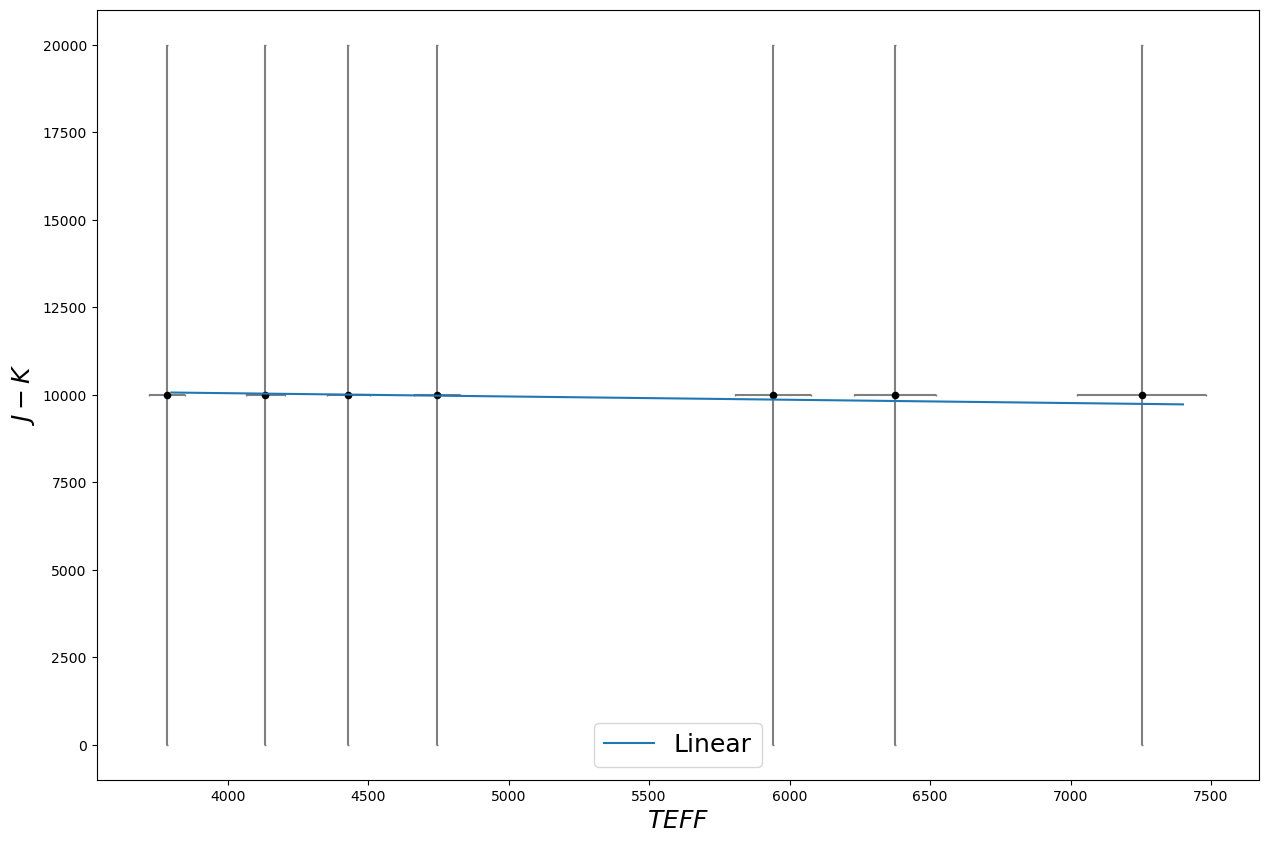

In [52]:

mask_1 = ((star['GLAT'][good] < -10) | (star['GLAT'][good] >10)) &(star['TEFF'][good] > -9999) & ((star['J'][good]-star['K'][good])>9999)
xdat = star['TEFF'][good][mask_1]
ydat = star['J'][good][mask_1]-star['K'][good][mask_1]
xdat_err = star['TEFF_ERR'][good][mask_1]
ydat_err = np.sqrt(star['J_ERR'][good][mask_1]**2+star['K_ERR'][good][mask_1]**2)


slope, intercept = mcFit2(linear, xdat, ydat, ydat_err, xdat_err, p0=[0., 9999.3])
print('Linear Fit:', "Slope:{:.3e}".format(slope)+" "+"Intercept:{:.3e}".format(intercept))
xfine = np.linspace(3800, 7400, 5)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(xdat,ydat,s=20,c='black')
ax.plot(xfine, linear(xfine, np.mean(slope), np.mean(intercept)), label='Linear')
ax.errorbar(xdat,ydat,xerr= xdat_err,yerr=ydat_err, c='tab:gray', 
            fmt='.', markersize=0.75, capsize=1 ,zorder=0)


plt.legend(loc='best', fontsize=18)
ax.set_xlabel('$TEFF$', fontsize=18)
ax.set_ylabel('$J-K$', fontsize=18)

plt.show()

This is the set of outlier points that can be fit by the linear function that was excluded from the TEFF vs. J-K profile in problem 4.